In [3]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Zadanie 1: n=2

## Według książki

In [104]:
def add_oracle_0(circ):
    circ.x(0)
    circ.x(1)
    circ.toffoli(0, 1, 2)
    circ.x(0)
    circ.x(1)
    
def add_oracle_1(circ):
    circ.x(0)
    circ.toffoli(0, 1, 2)
    circ.x(0)

def add_oracle_2(circ):
    circ.x(1)
    circ.toffoli(0, 1, 2)
    circ.x(1)
    
def add_oracle_3(circ):
    circ.toffoli(0, 1, 2)

In [105]:
n = 2
x_reg = QuantumRegister(n)
y_reg = QuantumRegister(1)
circ_book = QuantumCircuit(x_reg, y_reg)

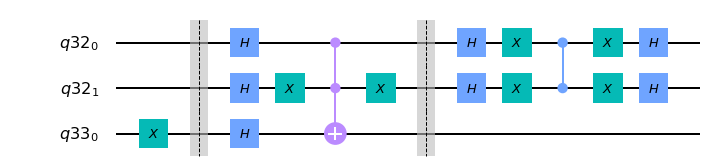

In [106]:
circ_book.x(y_reg[0])

circ_book.barrier(range(n+1))
for i in range(n+1):
    circ_book.h(i)

add_oracle_2(circ_book)
circ_book.barrier()
for i in range(n):
    circ_book.h(i)
for i in range(n):
    circ_book.x(i)
circ_book.cz(0, 1)
for i in range(n):
    circ_book.x(i)
for i in range(n):
    circ_book.h(i)

circ_book.draw()

Powyższy obwód jest zbudowany według rozwiązania książkowego. Pierwsza bramka X służy do zmiany kubitu wyjściowego z 0 na 1. Między barierami jest wyrocznia (i początkowe hadamardy) rozpoznająca liczbę 3 (10b). Potem iteracja Grover'a.

In [107]:
def run(circ, backend, n):
    c_reg = ClassicalRegister(n)
    qc = circ.copy()
    qc.add_register(c_reg)
    qc.barrier(range(n))
    qc.measure(range(n), range(n))
    job = execute(qc, backend, shots=1024)
    result = job.result()
    return result.get_counts(qc)

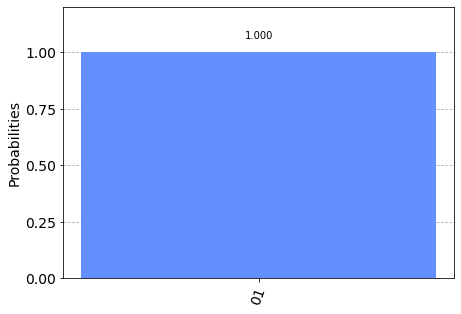

In [108]:
backend_sim = Aer.get_backend('qasm_simulator')
counts_book = run(circ_book, backend_sim, n)
plot_histogram(counts_book)

Symulator daje prawidłowy wynik z prawdopodobieństwem 1 - zgodnie z oczekiwaniami.

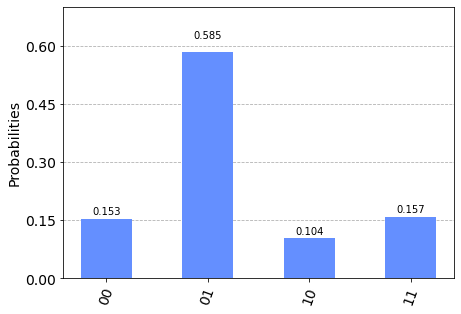

In [109]:
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_essex')
count_book_real = run(circ_book, backend, n)
plot_histogram(count_book_real)

Na prawdziwym urządzeniu jest gorzej - ale prawidowy wynik jest osiągany ze znaczenie większym prawodpodobieństwem niż pozostałe.

## Zoptymalizowane

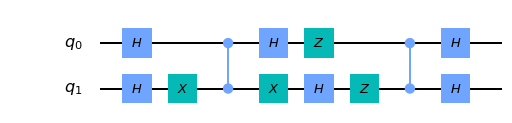

In [112]:
n = 2
circ_opt = QuantumCircuit(n)

for qubit in range(n):
    circ_opt.h(qubit)

# wyrocznia
circ_opt.x(1)
circ_opt.cz(0, 1)
circ_opt.x(1)
    
for qubit in range(n):
    circ_opt.h(qubit)
    
for qubit in range(n):
    circ_opt.z(qubit)
circ_opt.cz(0, 1)

for qubit in range(n):
    circ_opt.h(qubit)
    
circ_opt.draw()

Zoptymalizowany obówd - też znajduący liczbę 3 (10)

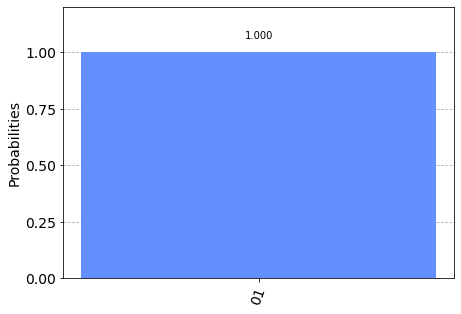

In [113]:
backend_sim = Aer.get_backend('qasm_simulator')
counts_opt = run(circ_opt, backend_sim, n)
plot_histogram(counts_opt)

działa :)

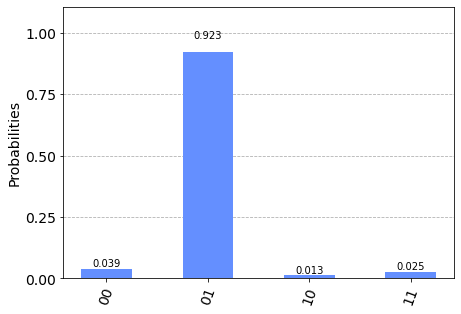

In [114]:
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_essex')
count_opt_real = run(circ_opt, backend, n)
plot_histogram(count_opt_real)

Znaczna róznica w stosunku do wersji niezoptymalizowanej. Prawie 100% szans na prawidłowy wynik.
Wynika to z mniejszej liczby bramek w obwodzie - mniej miejsc na dekoherencje.

# Zadanie 2: n > 2

Używam symulatora __QuIDE__ z lekko zmodyfikowanym kodem z upla - dodane Hadamardy sprawdzające i dodaktowe iteracje Grover'a. __n=4__.

![full_circ](resources/lab10/full_circ.png)

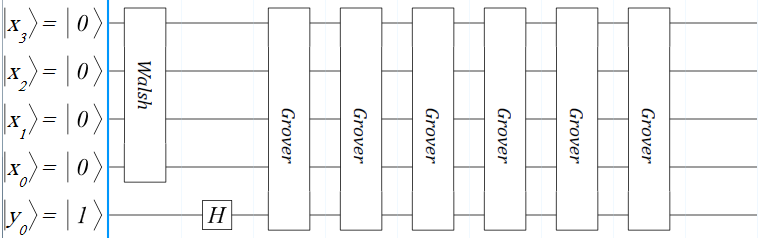

Tak wygląda wyrocznia - szuka liczby __0101__ - czyli __5__


![oracle](resources/lab10/oracle.png)


Stan początkowy - przed pierwszą iteracją - superpozycja wszystkich stanów:
![start](resources/lab10/start.png)


Piersza wyrocznia - zmiana amplitudy na przeciwną przy prawidłowej odpowiedzi:

![first_oracle](resources/lab10/first_oracle.png)


Po inwersji - widać, że prawdopodobieństwo wyniku z amplitudą z innym znakiem niż pozostałe znacznie się zwiększyło:

![first_inversion](resources/lab10/first_inversion.png)


### Ile iteracji potrzeba?
Zgodnie ze wzorem liczba iteracji powinna wynosić około:
$$i = \frac{\pi}{4} * \sqrt{N}$$, gdzie $$N = 2^n$$
W moim przypadku $n=4$, czyli $$i = \pi \approx 3$$.
Po trzech iteracjach Grover'a:

![3_iter](resources/lab10/3_iter.png)

Bardzo duże prawdopodobieństwo otrzymania prawidlowego wyniku - prawie 1.


Natomiast po kolejnej iteracji:

![4_iter](resources/lab10/4_iter.png)

Prawdopodobieństwo spada - zgadza się to ze wzorem, oraz z interpretacją geometetryczną - skoro każdy krok Grover'a to rotacja w stronę prawidłowego stanu, to w pewnym momencie "przeskoczymy" go i zaczniemy się oddalać. 

I rzeczywiście - każda kolejna iteracja jeszcze bardziej zmniejsza prawdopodobieństwo prawidłowego wyniku.